In [1]:
import sys
import json
import itertools
import numpy as np
from math import log
from random import random
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from collections import Counter, defaultdict

In [2]:
ZERO = 0.001
ONE  = 0.999

In [3]:
def cp(x, p):
    return p if x == 1 else (1-p)

def make_unconditional_set(p0):
    return lambda: random() < p0

def make_conditional_set_one_neighbour(p):
    return lambda n: (n) if (random() < p) else (1 - n)

def calculate_conditional_probs_for_1(p0, p):
    q = 1 - p
    joint_probs = {
        '000': p0 * p * p,
        '111': p0 * p * p,
        '010': p0 * q * q,
        '101': p0 * q * q,
        '110': p0 * p * q,
        '011': p0 * p * q,
        '001': p0 * p * q,
        '100': p0 * p * q,
    }
    return {
        '00': joint_probs['010']/(joint_probs['010']+joint_probs['000']),
        '01': joint_probs['011']/(joint_probs['011']+joint_probs['001']),
        '10': joint_probs['110']/(joint_probs['110']+joint_probs['100']),
        '11': joint_probs['111']/(joint_probs['111']+joint_probs['101']),
    }

def make_conditional_set_two_neighbours(p0, p):
    conditional_probs_for_1 = calculate_conditional_probs_for_1(p0, p)
    return lambda n1, n2: random() < conditional_probs_for_1[str(int(n1))+str(int(n2))]
    
def create_grid(rows, cols, p0, p):
    unconditional_set = make_unconditional_set(p0)
    conditional_set_one_neighbour = make_conditional_set_one_neighbour(p)
    conditional_set_two_neighbours = make_conditional_set_two_neighbours(p0, p)
    grid = np.zeros([rows, cols], dtype=np.bool)    
    # first element
    grid[0, 0] = unconditional_set()
    # first row
    for j in range(1, cols):
        grid[0, j] = conditional_set_one_neighbour(grid[0, j-1])
    # remaining rows
    for i in range(1, rows):
        grid[i, 0] = conditional_set_one_neighbour(grid[i-1, 0])
        for j in range(1, cols):
            grid[i, j] = conditional_set_two_neighbours(grid[i-1, j], grid[i, j-1])
    # make it symmetric
        if random() < 0.5:
        grid = np.fliplr(grid)
    if random() < 0.5:
        grid = np.flipud(grid)
    if rows == cols and random() < 0.5:
        grid = np.rot90(grid)
    return grid.astype(int)

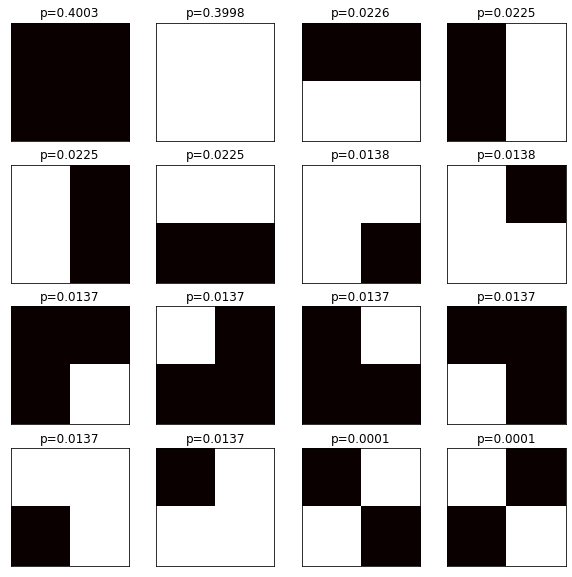

In [4]:
num_simulations = 10*1000*1000
rows, cols, p0, p, d = 2, 2, 0.5, 0.9, 4
frequencies = Counter()
for i in range(num_simulations):
    if i % 100 == 0:
        pct = int((i / num_simulations) * 10000) / 100
        print(f'Computing grid probabilities for the {rows}x{cols} spin glass, progress {pct}% ', end='\r')
        sys.stdout.flush()    
    grid = create_grid(rows, cols, p0, p)
    frequencies[json.dumps(grid.tolist())] += 1

fig, axs = plt.subplots(d, d, figsize=(10, 10))
for i, (grid, f) in enumerate(frequencies.most_common()):
    ax = axs[i // d, i % d]
    ax.imshow(np.array(json.loads(grid)), cmap='hot', vmin=0, vmax=1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'p=%0.4f' % (f/num_simulations))
plt.show()

In [5]:
def spin_glass_probability(grid, p0, p):
    grid_probability = 0
    # create all possible symmetry transformations of grid
    # all combinations of left-right, up-down mirroring and 90 degree rotation
    # total of 2^3 = 8 transformations, including identity, ie. no transformation
    # the symmetric probability of the grid is the average probability
    grid_probability += spin_glass_probability_inner(grid, p0, p)
    grid_probability += spin_glass_probability_inner(np.fliplr(grid), p0, p)
    grid_probability += spin_glass_probability_inner(np.flipud(grid), p0, p)
    grid_probability += spin_glass_probability_inner(np.fliplr(np.flipud(grid)), p0, p)
    normalization = 4
    if rows == cols:
        grid_probability += spin_glass_probability_inner(np.rot90(grid), p0, p)
        grid_probability += spin_glass_probability_inner(np.fliplr(np.rot90(grid)), p0, p)
        grid_probability += spin_glass_probability_inner(np.flipud(np.rot90(grid)), p0, p)
        grid_probability += spin_glass_probability_inner(np.fliplr(np.flipud(np.rot90(grid))), p0, p)
        normalization += 4
    return grid_probability / normalization
    #
    # without honoring symmetries:
    # return spin_glass_probability_inner(grid, p0, p)

def spin_glass_probability_inner(grid, p0, p):
    rows, cols = grid.shape
    cp2 = calculate_conditional_probs_for_1(p0, p)
    grid_probability = 1
    # first element
    grid_probability *= cp(grid[0, 0], p0)
    # first row
    for j in range(1, cols):
        grid_probability *= cp(grid[0, j-1] == grid[0, j], p)
    # remaining rows
    for i in range(1, rows):
        grid_probability *= cp(grid[i-1, 0] == grid[i, 0], p)
        for j in range(1, cols):
            grid_probability *= cp(grid[i, j], cp2['%d%d' % (grid[i-1, j], grid[i, j-1])])   
    return grid_probability

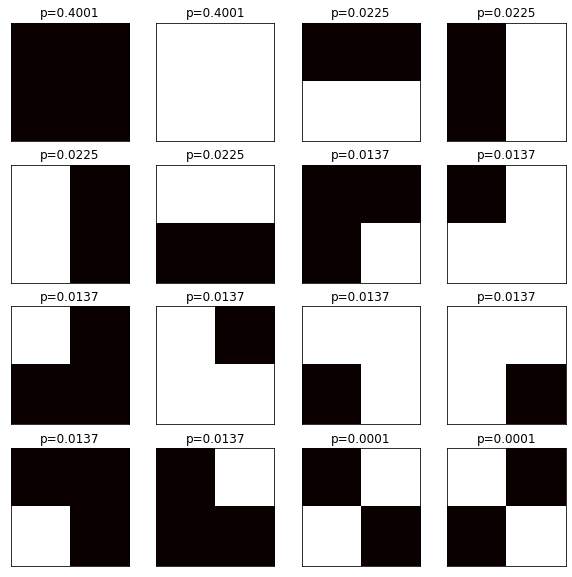

Total probability is 1.0


In [6]:
rows, cols, p0, p, d = 2, 2, 0.5, 0.9, 4
probabilities = Counter()
for li in list(itertools.product([0, 1], repeat=rows*cols)):
    grid = np.asarray(li).reshape(rows, cols).astype(int)
    grid_probability = spin_glass_probability(grid, p0, p)
    probabilities[json.dumps(grid.tolist())] = grid_probability

fig, axs = plt.subplots(d, d, figsize=(10, 10))
for i, (grid, grid_probability) in enumerate(probabilities.most_common()):
    ax = axs[i // d, i % d]
    ax.imshow(np.array(json.loads(grid)), cmap='hot', vmin=0, vmax=1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'p=%0.4f' % grid_probability)
plt.show()
    
print('Total probability is %.1f' % sum(probabilities.values()))

Text(0, 0.5, 'measured p')

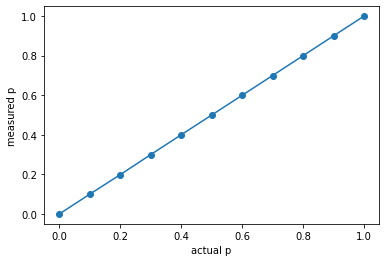

In [7]:
# consistency check
num_simulations = 100
rows, cols, p0 = 100, 100, 0.5
ps = []
for p in [ZERO, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ONE]:
    same, total = 0, 0
    for _ in range(num_simulations):
        grid = create_grid(rows, cols, p0, p)
        for i in range(0, rows-1):
            for j in range(0, cols-1):
                if grid[i, j] == grid[i+1, j]:
                    same += 1
                if grid[i, j] == grid[i, j+1]:
                    same += 1
                total += 2
    measured_p = same/total
    ps.append((p, measured_p))

plt.plot([x[0] for x in ps], [x[1] for x in ps], marker='o')
plt.xlabel('actual p')
plt.ylabel('measured p')

In [8]:
def spin_glass_entropy(rows, cols, p0, p, base=2):
    entropy = 0
    for i, li in enumerate(list(itertools.product([0, 1], repeat=rows*cols))):
        if i % 100 == 0:
            pct = int(i / (2**(rows*cols)) * 10000) / 100
            print(f'Computing entropies for the {rows}x{cols} spin glass, progress {pct}% ', end='\r')
            sys.stdout.flush()    
        grid = np.asarray(li).reshape(rows, cols).astype(int)
        grid_probability = spin_glass_probability(grid, p0, p)
        entropy -= grid_probability * log(grid_probability, base)
    return entropy

In [9]:
grid_entropies = []
for n in [1, 2, 3, 4]:
    for p in [ZERO, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ONE]:
        h = spin_glass_entropy(rows=n, cols=n, p0=p0, p=p)
        grid_entropies.append((n, p, h))

(0.0, 17.0)

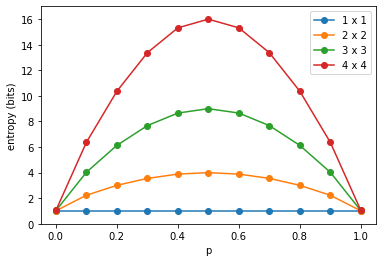

In [10]:
for n in sorted(list(set([x[0] for x in grid_entropies]))):
    xs = [x[1] for x in grid_entropies if x[0] == n]
    ys = [x[2] for x in grid_entropies if x[0] == n]
    plt.plot(xs, ys, marker='o')
plt.xlabel('p')
plt.ylabel('entropy (bits)')
plt.legend(sorted(list(set(['%d x %d' % (x[0], x[0]) for x in grid_entropies]))))
plt.ylim((0, 17))

(0.0, 17.0)

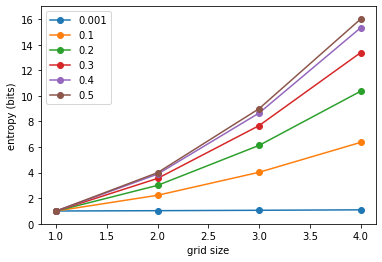

In [11]:
for p in [ZERO, 0.1, 0.2, 0.3, 0.4, 0.5]:
    xs = [x[0] for x in grid_entropies if x[1] == p]
    ys = [x[2] for x in grid_entropies if x[1] == p]
    plt.plot(xs, ys, marker='o')
plt.xlabel('grid size')
plt.ylabel('entropy (bits)')
plt.legend([ZERO, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.ylim((0, 17))